In [1]:
import Pkg
Pkg.add("Formatting")
using DataFrames, CSV
#using JLD
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots
using Distributions
using Graphs, LightGraphs, MetaGraphs, GraphPlot, GraphRecipes, SimpleWeightedGraphs
using Geodesy
using Formatting
using Combinatorics

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [122]:
#import dataset
schedule_2023 = CSV.read("official_2023.csv", DataFrame) #actual schedule for 2023
#schedule_2023 = permutedims(schedule_2023) #transpose the dataset
#delete!(schedule_2023, 25) #this row is the break between first and second half of the season
#show(schedule_2023, allcols=true, allrows=true)
schedule_2023

Row,i,j
,Int64,Int64
1,1,2
2,2,1
3,1,3
4,3,1
5,1,4
6,4,1
7,1,5
8,5,1
9,1,6


In [123]:
function visualize_loops(df)
    G = Graphs.SimpleDiGraph(25)
    for i in 1:38
        Graphs.add_edge!(G, df[i, :i], df[i, :j])
    end
    return G
end

visualize_loops (generic function with 1 method)

In [124]:
G = visualize_loops(schedule_2023)

{25, 38} directed simple Int64 graph

In [125]:
races_circuitref = ["bahrain", "jeddah", "albert_park", "shanghai", "baku", "miami", "imola", "monaco", "catalunya", "villeneuve", "red_bull_ring", "silverstone", "hungaroring", "spa", "zandvoort", "monza", "marina_bay", "suzuka", "losail", "americas", "rodriguez", "interlagos", "las_vegas", "yas_marina"];
all_df = CSV.read("circuits.csv", DataFrame)
select!(all_df, "circuitRef", "location", "lat", "lng")
#only keep rows for the races that we care about, i.e. 2024 schedule
df = all_df[in(races_circuitref).(all_df.circuitRef), :];
df = df[indexin(races_circuitref, df.circuitRef),:];

# get first #races circuitRef from initial df
circuitRefs = df[1:races-1, :circuitRef]

# create vector with string "home" and add circuitRefs to it
circuits = ["home"; circuitRefs]

25-element Vector{String}:
 "home"
 "bahrain"
 "jeddah"
 "albert_park"
 "shanghai"
 "baku"
 "miami"
 "imola"
 "monaco"
 "catalunya"
 "villeneuve"
 "red_bull_ring"
 "silverstone"
 "hungaroring"
 "spa"
 "zandvoort"
 "monza"
 "marina_bay"
 "suzuka"
 "losail"
 "americas"
 "rodriguez"
 "interlagos"
 "las_vegas"
 "yas_marina"

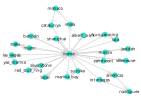

In [127]:
gplot(G, nodelabel=circuits)

## Calculate baseline cost

In [128]:
#Declare an empty 25 x 25 matrix
schedule_2023_matrix = zeros(25, 25)
for i in 1:38
    schedule_2023_matrix[schedule_2023[i, :i], schedule_2023[i, :j]] = 1
end

schedule_2023_matrix

25×25 Matrix{Float64}:
 0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  …  0.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [129]:
#Import weighted distance matrix 
distances = CSV.read("distance_matrix_updated.csv", DataFrame);
distances_matrix = Matrix(distances)

25×25 Matrix{Float64}:
     0.0    5233.95    4874.64  12281.8   …   8470.43   7571.14   5599.88
  5233.95      0.0     1257.42  10361.5      10191.0   10850.7     447.152
  4874.64   1257.42       0.0   10759.4       9387.08  10903.7    1613.81
 12281.8   10361.5    10759.4       0.0      10912.9   10916.7   10100.7
  8612.67   6497.96    7547.57   7518.32     12663.4    9363.14   6227.66
  4269.33   1587.46    2300.43  10840.3   …  10423.0    9945.97   1812.56
  6388.11  10429.7    10082.9   11982.6       6285.86   3454.44  10663.1
  1504.32   3956.27    3512.53  12133.8       8707.81   8732.96   4359.02
  1423.35   4255.09    3754.49  12232.2       8481.15   8601.7    4658.66
  1583.08   4611.4     4020.12  12339.2       8123.2    8507.89   5017.04
  4951.13   9204.84    8970.65  12317.0   …   7585.92   3572.49   9461.91
  1602.2    3852.59    3535.65  12067.7       8982.49   8662.08   4242.0
   986.96   5024.18    4702.93  12365.8       8637.25   7761.13   5392.55
  1886.31   3581.

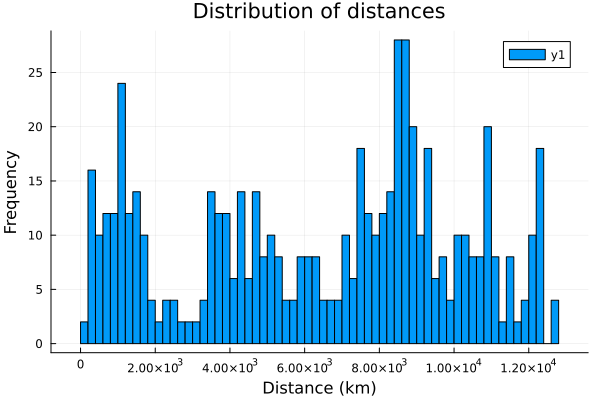

In [100]:
#Plot the distribution of distances
histogram(distances_matrix[distances_matrix .> 0], bins=100, xlabel="Distance (km)", ylabel="Frequency", title="Distribution of distances")

In [130]:
#Multiply both matrices and sum 
total_distance_2023 = sum(schedule_2023_matrix .* distances_matrix)
println("The total distance for the actual 2023 schedule is: ", format(round(total_distance_2023, digits=2), commas=true), " km")

The total distance for the actual 2023 schedule is: 189,507.97 km


In [131]:
# Emissions and attendance 

#Import emissions Matrix
emissions_matrix = Matrix(CSV.read("emissions_matrix_vrp.csv", DataFrame));

#Import attendance Matrix
attendance_matrix = Matrix(CSV.read("attendance_loss_matrix_vrp.csv", DataFrame));

#Multiply both matrices and sum
total_emissions_2023 = sum(schedule_2023_matrix .* emissions_matrix)
total_attendance_2023 = sum(schedule_2023_matrix .* attendance_matrix)

max_attendance = 24 * 250000
tot_loss = max_attendance - total_attendance_2023

println("The total emissions for the actual 2023 schedule is: ", format(round(total_emissions_2023, digits=2), commas=true), " kg")
println("The total attendance loss for the actual 2023 schedule is: ", format(round(tot_loss, digits=2), commas=true), " people")

The total emissions for the actual 2023 schedule is: 74,948,699.7 kg
The total attendance loss for the actual 2023 schedule is: 5,400,000 people


In [132]:
#Sanity Check with Guillaume's code
results = DataFrame(emissions = Float64[], attendance = Float64[], distance = Float64[])

df_vrp = schedule_2023
tot_em = 0
tot_loss = 0
tot_dist = 0
for row in eachrow(df_vrp)
    tot_em += emissions_matrix[row.i, row.j]
    tot_loss += attendance_matrix[row.i, row.j]
    tot_dist += distances_matrix[row.i, row.j]
end

max_attendance = 24 * 250000
tot_loss = max_attendance - tot_loss
push!(results, [tot_em, tot_loss, tot_dist])
results

Row,emissions,attendance,distance
,Float64,Float64,Float64
1,7.49487e7,5.4e6,189508.0


# Travelling Salesman Problem for Logistics - Baseline

In [133]:
#Import actual logistics DataFrame
logistics_2023 = CSV.read("logistics_official.csv", DataFrame);
logistics_2023

Row,i,j
,Int64,Int64
1,1,2
2,2,3
3,3,4
4,4,5
5,5,6
6,6,7
7,7,8
8,8,9
9,9,10


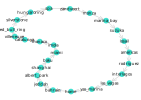

In [134]:
function visualize_loops(df)
    G = Graphs.SimpleDiGraph(25)
    for i in 1:25
        Graphs.add_edge!(G, df[i, :i], df[i, :j])
    end
    return G
end

G = visualize_loops(logistics_2023)

gplot(G, nodelabel=circuits)

In [135]:
#Declare an empty 25 x 25 matrix
logistics_2023_matrix = zeros(25, 25)
for i in 1:25
    logistics_2023_matrix[logistics_2023[i, :i], logistics_2023[i, :j]] = 1
end

logistics_2023_matrix

25×25 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [136]:
#Multiply both matrices and sum 
total_distance_logistics_2023 = sum(logistics_2023_matrix .* distances_matrix)
println("The total distance for the actual 2023 LOGISTICS schedule is: ", format(round(total_distance_logistics_2023, digits=2), commas=true), " km")

The total distance for the actual 2023 LOGISTICS schedule is: 131,865.15 km


In [137]:
#What about emissions and attendance?
df_vrp = schedule_2023

Row,i,j
,Int64,Int64
1,1,2
2,2,1
3,1,3
4,3,1
5,1,4
6,4,1
7,1,5
8,5,1
9,1,6


In [138]:
# Emissions - Generate Matrix
races = 25
home = 1
TH = 2
DH = 6
SH = races - 1 - 3 * TH - 2 * DH
subloops = SH + DH + TH

df_vrp = schedule_2023

function find_header(df, i)
    nodes = []
    j = df[i, :j]
    if j == home
        return
    end
    push!(nodes, j)
    next = find_header(df, findfirst(df.i .== j))
    # if next is not nothing
    if next !== nothing
        # flatten the array and push
        push!(nodes, next...)
    end
    return nodes
end

# extract double and triple headers from df_manual
sequences = Vector{Vector{Int}}()
for i in 1:nrow(df_vrp)
    if df_vrp[i, :i] == home
        push!(sequences, find_header(df_vrp, i))
    end
end

# get rid of single length sequences
sequences = sequences[map(length, sequences) .> 1]
new = []
for header in sequences
    if length(header) == 3
        # create two arrays of length 2
        # one for the first two nodes
        # one for the last two nodes
        # push them to sequences
        push!(new, header[1:2])
        push!(new, header[2:3])
        # remove the original one
        #deleteat!(sequences, findfirst(isequal(header), sequences))
    else
        push!(new, header)
    end
end

sequences = new

10-element Vector{Any}:
 [6, 7]
 [8, 9]
 [9, 10]
 [12, 13]
 [14, 15]
 [16, 17]
 [18, 19]
 [21, 22]
 [22, 23]
 [24, 25]

In [139]:
emissions_matrix_tsp = zeros(25, 25)

#Iterate through distance matrices

#If the [i,j] is in the sequences (i.e. they are consecutive), only 5 days to get there, automatically impose 5,000 km limit.
#Otherwise, you have at least 12 days to get there, impose 8,000 km limit.

#Driving 

for i in 1:25
    for j in 1:25
        if([i, j] in sequences) #races are consecutive, only 5 days to get there
            if(distances_matrix[i, j] <= 5000)
                emissions_matrix_tsp[i,j]=distances_matrix[i,j]*62 #you can drive, 62 grams/km
            else
                emissions_matrix_tsp[i,j]=distances_matrix[i,j]*500 #you have to fly, 500 grams/km
            end
        else #races are not consecutive, at least 12 days to get there
            if(distances_matrix[i, j] <= 8000)
                emissions_matrix_tsp[i,j]=distances_matrix[i,j]*62 #you can drive, 62 grams/km
            else
                emissions_matrix_tsp[i,j]=distances_matrix[i,j]*500 #you have to fly, 500 grams/km
            end
        end
    end       
end

In [116]:
# write to csv
#CSV.write("emissions_matrix_official_tsp.csv", DataFrame(emissions_matrix_tsp, :auto))

"emissions_matrix_official_tsp.csv"

In [140]:
attendance_loss_matrix_tsp = zeros(25, 25)

# devide attendance loss by 2 for all races not in sequences
for i in 1:25
    for j in 1:25
        if([i, j] in sequences)
            attendance_loss_matrix_tsp[i, j] = attendance_matrix[i, j]
        else
            attendance_loss_matrix_tsp[i, j] = attendance_matrix[i, j] / 2
        end
    end
end

In [118]:
# write to csv
#CSV.write("attendance_loss_matrix_official_tsp.csv", DataFrame(attendance_loss_matrix_tsp, :auto))

"attendance_loss_matrix_official_tsp.csv"

In [141]:
#Calculate total emissions and attendance loss

#Multiply both matrices and sum
total_emissions_tsp = sum(emissions_matrix_tsp .* logistics_2023_matrix)
total_attendance_loss_tsp = sum(attendance_loss_matrix_tsp .* logistics_2023_matrix)

max_attendance = 24 * 250000
tot_loss = max_attendance - total_attendance_loss_tsp

println("The total emissions for the actual 2023 LOGISTICS schedule is: ", format(round(total_emissions_tsp, digits=2), commas=true), " kg")
println("The total attendance loss for the actual 2023 LOGISTICS schedule is: ", format(round(tot_loss, digits=2), commas=true), " people")

The total emissions for the actual 2023 LOGISTICS schedule is: 37,686,304.91 kg
The total attendance loss for the actual 2023 LOGISTICS schedule is: 5,250,000 people


In [142]:
#Sanity Check with Guillaume's code
results = DataFrame(emissions = Float64[], attendance = Float64[], distance = Float64[])

tot_em = 0
tot_loss = 0
tot_dist = 0
for row in eachrow(logistics_2023)
    tot_em += emissions_matrix_tsp[row.i, row.j]
    tot_loss += attendance_loss_matrix_tsp[row.i, row.j]
    tot_dist += distances_matrix[row.i, row.j]
end

max_attendance = 24 * 250000
tot_loss = max_attendance - tot_loss
push!(results, [tot_em, tot_loss, tot_dist])
results

Row,emissions,attendance,distance
,Float64,Float64,Float64
1,3.76863e7,5.25e6,1.31865e5


In [145]:
distances[24,25]*500

5.490113241813291e6

In [146]:
distances[24,25]*62

680774.0419848481

# TSP For the actual solution from the VRP

In [36]:
#import results from VRP
vrp_optimal = CSV.read("result_vrp.csv", DataFrame);
#import distance matrix
distance_matrix_up = CSV.read("distance_matrix_updated.csv", DataFrame);
distance_matrix_up = Matrix(distance_matrix_up);

In [37]:
races = 25
home = 1
TH = 2
DH = 6
SH = races - 1 - 3 * TH - 2 * DH
subloops = SH + DH + TH
V = 1:races
V_0 = 2:races

2:25

In [38]:
races_circuitref = ["bahrain", "jeddah", "albert_park", "shanghai", "baku", "miami", "imola", "monaco", "catalunya", "villeneuve", "red_bull_ring", "silverstone", "hungaroring", "spa", "zandvoort", "monza", "marina_bay", "suzuka", "losail", "americas", "rodriguez", "interlagos", "las_vegas", "yas_marina"];
all_df = CSV.read("circuits.csv", DataFrame)
select!(all_df, "circuitRef", "location", "lat", "lng")
#only keep rows for the races that we care about, i.e. 2024 schedule
df = all_df[in(races_circuitref).(all_df.circuitRef), :];
df = df[indexin(races_circuitref, df.circuitRef),:];

# get first #races circuitRef from initial df
circuitRefs = df[1:races-1, :circuitRef]

# create vector with string "home" and add circuitRefs to it
circuits = ["home"; circuitRefs];

In [39]:
function visualize_loops(df)
    G = Graphs.SimpleDiGraph(length(V))
    for i in 1:nrow(df)
        Graphs.add_edge!(G, df[i, :i], df[i, :j])
    end
    return G
end

visualize_loops (generic function with 1 method)

In [40]:
G = visualize_loops(vrp_optimal)

{25, 38} directed simple Int64 graph

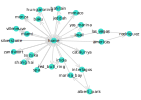

In [41]:
gplot(G, nodelabel=circuits)

In [42]:
#Declare an empty 25 x 25 matrix
optimal_2023_matrix = zeros(25, 25)
for i in 1:38
    optimal_2023_matrix[vrp_optimal[i, :i], vrp_optimal[i, :j]] = 1
end

optimal_2023_matrix

25×25 Matrix{Float64}:
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  …  0.0  1.0  1.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [43]:
#Calculate total distance just as quality check
total_distance_optimal = sum(optimal_2023_matrix .* distance_matrix_up)
println("The total distance for the optimal 2023 schedule is: ", format(round(total_distance_optimal, digits=2), commas=true), " km")

The total distance for the optimal 2023 schedule is: 135,925.01 km


In [44]:
#What about logistics?
tsp_optimal = CSV.read("result_tsp.csv", DataFrame);

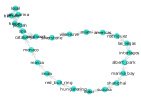

In [45]:
function visualize_loops(df)
    G = Graphs.SimpleDiGraph(25)
    for i in 1:25
        Graphs.add_edge!(G, df[i, :i], df[i, :j])
    end
    return G
end

G = visualize_loops(tsp_optimal)

gplot(G, nodelabel=circuits)

In [46]:
#Declare an empty 25 x 25 matrix
logistics_optimal_matrix = zeros(25, 25)
for i in 1:25
    logistics_optimal_matrix[tsp_optimal[i, :i], tsp_optimal[i, :j]] = 1
end

logistics_optimal_matrix

25×25 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [47]:
#Multiply both matrices and sum 
total_distance_logistics_optimal = sum(logistics_optimal_matrix .* distance_matrix_up)
println("The total distance for the optimal LOGISTICS schedule is: ", format(round(total_distance_logistics_optimal, digits=2), commas=true), " km")

The total distance for the optimal LOGISTICS schedule is: 67,773.17 km


In [48]:
#Total distance including logistics_ 
total_distance_optimal_both=total_distance_optimal + total_distance_logistics_optimal
println("The total distance for the actual 2023 schedule including logistics is: ", format(round(total_distance_optimal_both, digits=2), commas=true), " km")

The total distance for the actual 2023 schedule including logistics is: 203,698.18 km


In [51]:
# Recovering double and triple headers from solution

function find_header(df, i)
    nodes = []
    j = df[i, :j]
    if j == home
        return
    end
    push!(nodes, j)
    next = find_header(df, findfirst(df.i .== j))
    # if next is not nothing
    if next !== nothing
        # flatten the array and push
        push!(nodes, next...)
    end
    return nodes
end

# extract double and triple headers from df_manual
sequences = Vector{Vector{Int}}()
for i in 1:nrow(vrp_optimal)
    if vrp_optimal[i, :i] == home
        push!(sequences, find_header(vrp_optimal, i))
    end
end

# get rid of single length sequences
sequences = sequences[map(length, sequences) .> 1]

8-element Vector{Vector{Int64}}:
 [3, 2]
 [5, 19]
 [6, 14]
 [11, 7]
 [12, 8]
 [20, 25]
 [21, 22, 24]
 [23, 4, 18]

In [52]:
sequences
#print the sequences according to their indices in circuits
for sequence in sequences
    println(circuits[sequence])
end

["jeddah", "bahrain"]
["shanghai", "suzuka"]
["baku", "hungaroring"]
["villeneuve", "miami"]
["red_bull_ring", "imola"]
["losail", "yas_marina"]
["americas", "rodriguez", "las_vegas"]
["interlagos", "albert_park", "marina_bay"]


In [55]:
for header in sequences
    if length(header) == 3
        # create two arrays of length 2
        # one for the first two nodes
        # one for the last two nodes
        # push them to sequences
        push!(sequences, header[1:2])
        push!(sequences, header[2:3])
        # remove the original one
        deleteat!(sequences, findfirst(isequal(header), sequences))
    end
end

In [56]:
sequences
#print the sequences according to their indices in circuits
for sequence in sequences
    println(circuits[sequence])
end

["jeddah", "bahrain"]
["shanghai", "suzuka"]
["baku", "hungaroring"]
["villeneuve", "miami"]
["red_bull_ring", "imola"]
["losail", "yas_marina"]
["americas", "rodriguez"]
["rodriguez", "las_vegas"]
["interlagos", "albert_park"]
["albert_park", "marina_bay"]


In [78]:
V = 1:races
V_0 = 2:races
# remove first and last races from V_0
ind_start = findall(x->x=="bahrain", df[!, "circuitRef"])[1] + 1
ind_end = findall(x->x=="yas_marina", df[!, "circuitRef"])[1] + 1
#ind_end = 15
# remove ind_start and ind_end from V_0
V_1 = setdiff(V_0, [ind_start, ind_end])

all_S = Combinatorics.powerset(V_1, 2, length(V) - 2);
all_S = collect(all_S);

In [79]:
model2 = Model(Gurobi.Optimizer)
set_optimizer_attribute(model2, "OutputFlag", 1)
set_optimizer_attribute(model2, "Threads", 20)
#set_optimizer_attribute(model2, "MIPGap", 0.005)
set_optimizer_attribute(model2, "TimeLimit", 600)

# variables
@variable(model2, x[i in V, j in V], Bin)
#@variable(model2, subloops >= 1)

# constraints
# each circuit can only be visited once
@constraint(model2, only_one_in[j in V_0], sum(x[i, j] for i in V) == 1)
@constraint(model2, only_one_out[i in V_0], sum(x[i, j] for j in V) == 1) 

# we cannot go from a circuit to itself
@constraint(model2, no_self_connect[i in V], x[i, i] == 0)

# we must start and end at home, only 1 subloop since we want to cover everything in one go
@constraint(model2, K_petals_in, sum(x[i, 1] for i in V_0) == 1)
@constraint(model2, K_petals_out, sum(x[1, j] for j in V_0) == 1)

# no subloops that do not connect to home
for S in all_S
    @constraint(model2, sum(x[i, j] for i in S, j in S) <= length(S) - 1)
end

# add constraints for double and triple headers
for (i, j) in sequences
    @constraint(model2, x[i, j] == 1)
end

# add constraints for begin and end race
#@constraint(model2, x[home, ind_start] == 1)
#@constraint(model2, [i in V_1], x[i, ind_start] == 0)
@constraint(model2, x[ind_end, home] == 1)
@constraint(model2, [j in V_1], x[ind_end, j] == 0)
#@constraint(model2, x[ind_start, ind_end] == 0)

#objective
@objective(model2, Min, sum(sum(x[i, j] * distance_matrix_up[i, j] for i in V) for j in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter Threads to value 20
Set parameter TimeLimit to value 600


In [ ]:
optimize!(model2)

# Introducing the trade off between distances and emissions

Airplanes emit 500 grams of CO2 per metric ton per km. 

Trucks emit 62 grams of CO2 per metric ton per km. 

(For reference: Ships emit 30 grams of CO2 per metric ton per km. Altough let's no use it.)

1,000 km limit per day for driving.

If it's from race to race you have one week -> 5 days to get there -> 5,000 km limit 

If races are not consecutive, you have at least two weeks -> 12 days to get there -> 12,000 km limit

In [122]:
emissions_matrix = zeros(25, 25)

#Iterate through distance matrices

#If the [i,j] is in the sequences (i.e. they are consecutive), only 5 days to get there, automatically impose 5,000 km limit.
#Otherwise, you have at least 12 days to get there, impose 12,000 km limit.

#Driving 

for i in 1:25
    for j in 1:25
        if([i, j] in sequences) #races are consecutive, only 5 days to get there
            if(distance_matrix_up[i, j] <= 5000)
                emissions_matrix[i,j]=distance_matrix_up[i,j]*62 #you can drive, 62 grams/km
            else
                emissions_matrix[i,j]=distance_matrix_up[i,j]*500 #you have to fly, 500 grams/km
            end
        else #races are not consecutive, at least 12 days to get there
            if(distance_matrix_up[i, j] <= 12000)
                emissions_matrix[i,j]=distance_matrix_up[i,j]*62 #you can drive, 62 grams/km
            else
                emissions_matrix[i,j]=distance_matrix_up[i,j]*500 #you have to fly, 500 grams/km
            end
        end
    end       
end

emissions_matrix

25×25 Matrix{Float64}:
      0.0             3.24505e5  …       4.69411e5       3.47193e5
      3.24505e5       0.0                6.72745e5   27723.4
      3.02228e5   77959.9                6.76031e5       1.00056e5
      6.14088e6       6.42414e5          6.76838e5       6.26243e5
      5.33986e5       4.02874e5          5.80514e5       3.86115e5
      2.64699e5   98422.8        …       6.1665e5   112379.0
      3.96063e5       6.46638e5          2.14175e5       6.61111e5
  93267.6        245289.0                5.41443e5  270259.0
  88247.9             2.63816e5          5.33305e5  288837.0
  98150.9             2.85907e5          5.27489e5       3.11056e5
 306970.0             5.707e5    …       2.21494e5       5.86639e5
  99336.4             2.38861e5          5.37049e5       2.63004e5
  61191.6             3.11499e5          4.8119e5   334338.0
 116951.0        222068.0                5.44794e5       2.45843e5
  73221.1             2.81663e5          5.04578e5  305018.0
  72099.

In [123]:
#Turn this matrix into dataframe
emissions_matrix_df = DataFrame(emissions_matrix, :auto)
CSV.write("emissions_matrix.csv", emissions_matrix_df)

"emissions_matrix.csv"

In [ ]:
@objective(model2, Min, sum(sum(x[i, j] * distance_matrix_up[i, j] for i in V) for j in V));

In [ ]:
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 1)
set_optimizer_attribute(model, "Threads", 20)
set_optimizer_attribute(model, "MIPGap", 0.01)

# variables
@variable(model, x[i in V, j in V], Bin)

# constraints
# each circuit can only be visited once
@constraint(model, only_one_in[j in V_0], sum(x[i, j] for i in V) == 1)
@constraint(model, only_one_out[i in V_0], sum(x[i, j] for j in V) == 1) 

# we cannot go from a circuit to itself
@constraint(model, no_self_connect[i in V], x[i, i] == 0)

#Connections formed in the firs optimization problem VRP
@constraint(model, x[a,b] == 1) #First part of a triple header
@constraint(model, x[b,c] == 1) #Second part of a triple header
@constraint(model, x[d,e] == 1) #One double header
@constraint(model, x[f,g] == 1) #Another double header

# we must start and end at home and the number of loops away from home is subloops
@constraint(model, K_petals_in, sum(x[i, 1] for i in V_0) == 1)
@constraint(model, K_petals_out, sum(x[1, j] for j in V_0) == 1)

# no subloops that do not connect to home
for S in all_S
    @constraint(model, sum(x[i, j] for i in S, j in S) <= length(S) - 1)
end

#objective
@objective(model, Min, sum(sum(x[i, j] * distance_matrix[i, j] for i in V) for j in V));

# Tradeoff between distance and attendance / revenue

From the optimal TSP, we can see that Monza, Monaco, Catalunya happen consecutively. Also Spa and Zandvoort.
Let's penalize this so that different routes are taken. 

Ths distance between Spa and Zandvoort is merely 230 km according to Google. 
Monza Monaco: 330 km
Monaco Catalunya: 683 km

In [67]:
revenueloss_matrix = zeros(25, 25)

#Iterate through distance matrices

#If the [i,j] is in the sequences (i.e. they are consecutive), they are close, automatically impose a big loss. 
#Otherwise, you can choose to have them close or not, impose different losses. 

for i in 1:25
    for j in 1:25
        if([i, j] in sequences) #races are consecutive, impose the same loss, doesn't really matter, they are fixed
            revenueloss_matrix[i,j]=distance_matrix_up[i,j]*10 #arbtirary loss of 10 times the distance
        else #races are not consecutive, we can impose different losses
            if(distance_matrix_up[i, j] <= 250) #Too close, huge loss
                revenueloss_matrix[i,j]=distance_matrix_up[i,j]*1000 
            elseif(distance_matrix_up[i, j] <= 500) #Moderately close, big loss
                revenueloss_matrix[i,j]=distance_matrix_up[i,j]*100 
            elseif(distance_matrix_up[i, j] <= 1000) #Moderately far, small loss
                revenueloss_matrix[i,j]=distance_matrix_up[i,j]*10 
            else #Very far, no loss
                revenueloss_matrix[i,j]=distance_matrix_up[i,j]*1
            end
        end
    end       
end

revenueloss_matrix

25×25 Matrix{Float64}:
     0.0    5233.95        4874.64  …   8470.43   7571.14   5599.88
  5233.95      0.0         1257.42     10191.0   10850.7   44715.2
  4874.64  12574.2            0.0       9387.08  10903.7    1613.81
 12281.8   10361.5        10759.4      10912.9   10916.7   10100.7
  8612.67   6497.96        7547.57     12663.4    9363.14   6227.66
  4269.33   1587.46        2300.43  …  10423.0    9945.97   1812.56
  6388.11  10429.7        10082.9       6285.86   3454.44  10663.1
  1504.32   3956.27        3512.53      8707.81   8732.96   4359.02
  1423.35   4255.09        3754.49      8481.15   8601.7    4658.66
  1583.08   4611.4         4020.12      8123.2    8507.89   5017.04
  4951.13   9204.84        8970.65  …   7585.92   3572.49   9461.91
  1602.2    3852.59        3535.65      8982.49   8662.08   4242.0
  9869.6    5024.18        4702.93      8637.25   7761.13   5392.55
  1886.31   3581.74        3344.47      9193.41   8787.0    3965.21
  1180.99   4542.94        42

In [69]:
#save this matrix to a csv file
revenueloss_matrix_df = DataFrame(revenueloss_matrix, :auto)
CSV.write("revenueloss_matrix.csv", revenueloss_matrix_df)

"revenueloss_matrix.csv"